In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import random
from joblib import parallel_backend
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
import gc


In [66]:
import pandas
import os

# This query represents dataset "Eczema" for domain "person" and was generated for All of Us Controlled Tier Dataset v7
dataset_57765325_person_sql = """
    SELECT
        person.person_id,
        person.gender_concept_id,
        p_gender_concept.concept_name as gender,
        person.birth_datetime as date_of_birth,
        person.race_concept_id,
        p_race_concept.concept_name as race,
        person.ethnicity_concept_id,
        p_ethnicity_concept.concept_name as ethnicity,
        person.sex_at_birth_concept_id,
        p_sex_at_birth_concept.concept_name as sex_at_birth 
    FROM
        `""" + os.environ["WORKSPACE_CDR"] + """.person` person 
    LEFT JOIN
        `""" + os.environ["WORKSPACE_CDR"] + """.concept` p_gender_concept 
            ON person.gender_concept_id = p_gender_concept.concept_id 
    LEFT JOIN
        `""" + os.environ["WORKSPACE_CDR"] + """.concept` p_race_concept 
            ON person.race_concept_id = p_race_concept.concept_id 
    LEFT JOIN
        `""" + os.environ["WORKSPACE_CDR"] + """.concept` p_ethnicity_concept 
            ON person.ethnicity_concept_id = p_ethnicity_concept.concept_id 
    LEFT JOIN
        `""" + os.environ["WORKSPACE_CDR"] + """.concept` p_sex_at_birth_concept 
            ON person.sex_at_birth_concept_id = p_sex_at_birth_concept.concept_id  
    WHERE
        person.PERSON_ID IN (SELECT
            distinct person_id  
        FROM
            `""" + os.environ["WORKSPACE_CDR"] + """.cb_search_person` cb_search_person  
        WHERE
            cb_search_person.person_id IN (SELECT
                criteria.person_id 
            FROM
                (SELECT
                    DISTINCT person_id, entry_date, concept_id 
                FROM
                    `""" + os.environ["WORKSPACE_CDR"] + """.cb_search_all_events` 
                WHERE
                    (concept_id IN(SELECT
                        DISTINCT c.concept_id 
                    FROM
                        `""" + os.environ["WORKSPACE_CDR"] + """.cb_criteria` c 
                    JOIN
                        (SELECT
                            CAST(cr.id as string) AS id       
                        FROM
                            `""" + os.environ["WORKSPACE_CDR"] + """.cb_criteria` cr       
                        WHERE
                            concept_id IN (133835)       
                            AND full_text LIKE '%_rank1]%'      ) a 
                            ON (c.path LIKE CONCAT('%.', a.id, '.%') 
                            OR c.path LIKE CONCAT('%.', a.id) 
                            OR c.path LIKE CONCAT(a.id, '.%') 
                            OR c.path = a.id) 
                    WHERE
                        is_standard = 1 
                        AND is_selectable = 1) 
                    AND is_standard = 1 )) criteria ) )"""

dataset_57765325_person_df = pandas.read_gbq(
    dataset_57765325_person_sql,
    dialect="standard",
    use_bqstorage_api=("BIGQUERY_STORAGE_API_ENABLED" in os.environ),
    progress_bar_type="tqdm_notebook")

dataset_57765325_person_df.head(5)

Downloading:   0%|          | 0/16460 [00:00<?, ?rows/s]

,person_id,gender_concept_id,gender,date_of_birth,race_concept_id,race,ethnicity_concept_id,ethnicity,sex_at_birth_concept_id,sex_at_birth
0,1389218,1177221,I prefer not to answer,1972-06-15 00:00:00+00:00,1177221,I prefer not to answer,903079,PMI: Prefer Not To Answer,1177221,I prefer not to answer
1,3006131,45880669,Male,1961-06-15 00:00:00+00:00,1177221,I prefer not to answer,903079,PMI: Prefer Not To Answer,1177221,I prefer not to answer
2,1382327,903096,PMI: Skip,1951-06-15 00:00:00+00:00,1177221,I prefer not to answer,903079,PMI: Prefer Not To Answer,1177221,I prefer not to answer
3,1861144,45878463,Female,1957-06-15 00:00:00+00:00,1177221,I prefer not to answer,903079,PMI: Prefer Not To Answer,1177221,I prefer not to answer
4,2864529,2000000002,"Not man only, not woman only, prefer not to an...",1961-06-15 00:00:00+00:00,45882607,None of these,1586148,What Race Ethnicity: Race Ethnicity None Of These,1177221,I prefer not to answer


In [3]:
import pandas
import os

# This query represents dataset "Eczema" for domain "survey" and was generated for All of Us Controlled Tier Dataset v7
dataset_88415271_survey_sql = """
    SELECT
        answer.person_id,
        answer.survey_datetime,
        answer.survey,
        answer.question_concept_id,
        answer.question,
        answer.answer_concept_id,
        answer.answer,
        answer.survey_version_concept_id,
        answer.survey_version_name  
    FROM
        `""" + os.environ["WORKSPACE_CDR"] + """.ds_survey` answer   
    WHERE
        (
            question_concept_id IN (SELECT
                DISTINCT concept_id                         
            FROM
                `""" + os.environ["WORKSPACE_CDR"] + """.cb_criteria` c                         
            JOIN
                (SELECT
                    CAST(cr.id as string) AS id                               
                FROM
                    `""" + os.environ["WORKSPACE_CDR"] + """.cb_criteria` cr                               
                WHERE
                    concept_id IN (1586134, 1585855, 1585710, 43528895, 40192389, 1740639)                               
                    AND domain_id = 'SURVEY') a 
                    ON (c.path like CONCAT('%', a.id, '.%'))                         
            WHERE
                domain_id = 'SURVEY'                         
                AND type = 'PPI'                         
                AND subtype = 'QUESTION')
        )  
        AND (
            answer.PERSON_ID IN (SELECT
                distinct person_id  
            FROM
                `""" + os.environ["WORKSPACE_CDR"] + """.cb_search_person` cb_search_person  
            WHERE
                cb_search_person.person_id IN (SELECT
                    criteria.person_id 
                FROM
                    (SELECT
                        DISTINCT person_id, entry_date, concept_id 
                    FROM
                        `""" + os.environ["WORKSPACE_CDR"] + """.cb_search_all_events` 
                    WHERE
                        (concept_id IN(SELECT
                            DISTINCT c.concept_id 
                        FROM
                            `""" + os.environ["WORKSPACE_CDR"] + """.cb_criteria` c 
                        JOIN
                            (SELECT
                                CAST(cr.id as string) AS id       
                            FROM
                                `""" + os.environ["WORKSPACE_CDR"] + """.cb_criteria` cr       
                            WHERE
                                concept_id IN (133835)       
                                AND full_text LIKE '%_rank1]%'      ) a 
                                ON (c.path LIKE CONCAT('%.', a.id, '.%') 
                                OR c.path LIKE CONCAT('%.', a.id) 
                                OR c.path LIKE CONCAT(a.id, '.%') 
                                OR c.path = a.id) 
                        WHERE
                            is_standard = 1 
                            AND is_selectable = 1) 
                        AND is_standard = 1 )) criteria ) )
        )"""

dataset_88415271_survey_df = pandas.read_gbq(
    dataset_88415271_survey_sql,
    dialect="standard",
    use_bqstorage_api=("BIGQUERY_STORAGE_API_ENABLED" in os.environ),
    progress_bar_type="tqdm_notebook")

dataset_88415271_survey_df.head(5)

Downloading:   0%|          | 0/2968224 [00:00<?, ?rows/s]

,person_id,survey_datetime,survey,question_concept_id,question,answer_concept_id,answer,survey_version_concept_id,survey_version_name
0,1063359,2020-03-16 20:36:09+00:00,Personal and Family Health History,1384448,About how old were you when you were first tol...,1385344,About how old were you when you were first tol...,<NA>,None
1,2253803,2018-11-15 23:16:09+00:00,Personal and Family Health History,1384448,About how old were you when you were first tol...,1385503,About how old were you when you were first tol...,<NA>,None
2,2371818,2022-04-19 01:05:43+00:00,Personal and Family Health History,43530496,About how old were you when you were first tol...,1384797,About how old were you when you were first tol...,<NA>,None
3,2006942,2020-01-19 02:20:37+00:00,Personal and Family Health History,43530496,About how old were you when you were first tol...,1384797,About how old were you when you were first tol...,<NA>,None
4,1339958,2021-08-28 14:12:44+00:00,Personal and Family Health History,43530496,About how old were you when you were first tol...,1384797,About how old were you when you were first tol...,<NA>,None


In [4]:
eczema_survey_processed = dataset_88415271_survey_df.groupby(['person_id', 'survey'])['answer'].agg('max').reset_index()
eczema_survey_processed = eczema_survey_processed.pivot(index='person_id', columns='survey', values='answer')
eczema_survey_processed = eczema_survey_processed.reset_index()
eczema_survey_processed.fillna('unknown', inplace=True)

del dataset_88415271_survey_df
gc.collect()

21

In [5]:
import pandas
import os

# This query represents dataset "Eczema" for domain "fitbit_heart_rate_summary" and was generated for All of Us Controlled Tier Dataset v7
dataset_57765325_fitbit_heart_rate_summary_sql = """
    SELECT
        heart_rate_summary.person_id,
        heart_rate_summary.date,
        heart_rate_summary.zone_name,
        heart_rate_summary.min_heart_rate,
        heart_rate_summary.max_heart_rate,
        heart_rate_summary.minute_in_zone,
        heart_rate_summary.calorie_count 
    FROM
        `""" + os.environ["WORKSPACE_CDR"] + """.heart_rate_summary` heart_rate_summary   
    WHERE
        heart_rate_summary.PERSON_ID IN (SELECT
            distinct person_id  
        FROM
            `""" + os.environ["WORKSPACE_CDR"] + """.cb_search_person` cb_search_person  
        WHERE
            cb_search_person.person_id IN (SELECT
                criteria.person_id 
            FROM
                (SELECT
                    DISTINCT person_id, entry_date, concept_id 
                FROM
                    `""" + os.environ["WORKSPACE_CDR"] + """.cb_search_all_events` 
                WHERE
                    (concept_id IN(SELECT
                        DISTINCT c.concept_id 
                    FROM
                        `""" + os.environ["WORKSPACE_CDR"] + """.cb_criteria` c 
                    JOIN
                        (SELECT
                            CAST(cr.id as string) AS id       
                        FROM
                            `""" + os.environ["WORKSPACE_CDR"] + """.cb_criteria` cr       
                        WHERE
                            concept_id IN (133835)       
                            AND full_text LIKE '%_rank1]%'      ) a 
                            ON (c.path LIKE CONCAT('%.', a.id, '.%') 
                            OR c.path LIKE CONCAT('%.', a.id) 
                            OR c.path LIKE CONCAT(a.id, '.%') 
                            OR c.path = a.id) 
                    WHERE
                        is_standard = 1 
                        AND is_selectable = 1) 
                    AND is_standard = 1 )) criteria ) )"""

dataset_57765325_fitbit_heart_rate_summary_df = pandas.read_gbq(
    dataset_57765325_fitbit_heart_rate_summary_sql,
    dialect="standard",
    use_bqstorage_api=("BIGQUERY_STORAGE_API_ENABLED" in os.environ),
    progress_bar_type="tqdm_notebook")

dataset_57765325_fitbit_heart_rate_summary_df.head(5)

Downloading:   0%|          | 0/670248 [00:00<?, ?rows/s]

,person_id,date,zone_name,min_heart_rate,max_heart_rate,minute_in_zone,calorie_count
0,2818077,2021-07-14,Out of Range,30,72,1228,1175.85120
1,2818077,2022-06-02,Out of Range,30,72,1166,1205.94090
2,2818077,2022-04-18,Out of Range,30,72,1319,1353.52302
3,2818077,2022-06-28,Out of Range,30,72,1047,1114.63338
4,2818077,2021-09-06,Out of Range,30,72,985,915.87760


In [6]:
fitbit_heart_rate = (
    dataset_57765325_fitbit_heart_rate_summary_df.groupby('person_id')
    .agg(
        mean_min_heart_rate = ('min_heart_rate', 'mean'),
        mean_max_heart_rate = ('max_heart_rate', 'mean'),
        mean_minute_in_zone=('minute_in_zone', 'mean'),
        max_minute_in_zone=('minute_in_zone', 'max'),
        heart_rate_count=('calorie_count', 'count'),
        calorie_mean=('calorie_count', 'mean'),
        calorie_max=('calorie_count', 'max'),
    )
    .reset_index()
)
fitbit_heart_rate

del dataset_57765325_fitbit_heart_rate_summary_df
gc.collect()

174

In [7]:
import pandas
import os

# This query represents dataset "Eczema" for domain "fitbit_heart_rate_level" and was generated for All of Us Controlled Tier Dataset v7
dataset_57765325_fitbit_heart_rate_level_sql = """
    SELECT
        heart_rate_minute_level.person_id,
        CAST(heart_rate_minute_level.datetime AS DATE) as date,
        AVG(heart_rate_value) avg_rate 
    FROM
        `""" + os.environ["WORKSPACE_CDR"] + """.heart_rate_minute_level` heart_rate_minute_level   
    WHERE
        heart_rate_minute_level.PERSON_ID IN (SELECT
            distinct person_id  
        FROM
            `""" + os.environ["WORKSPACE_CDR"] + """.cb_search_person` cb_search_person  
        WHERE
            cb_search_person.person_id IN (SELECT
                criteria.person_id 
            FROM
                (SELECT
                    DISTINCT person_id, entry_date, concept_id 
                FROM
                    `""" + os.environ["WORKSPACE_CDR"] + """.cb_search_all_events` 
                WHERE
                    (concept_id IN(SELECT
                        DISTINCT c.concept_id 
                    FROM
                        `""" + os.environ["WORKSPACE_CDR"] + """.cb_criteria` c 
                    JOIN
                        (SELECT
                            CAST(cr.id as string) AS id       
                        FROM
                            `""" + os.environ["WORKSPACE_CDR"] + """.cb_criteria` cr       
                        WHERE
                            concept_id IN (133835)       
                            AND full_text LIKE '%_rank1]%'      ) a 
                            ON (c.path LIKE CONCAT('%.', a.id, '.%') 
                            OR c.path LIKE CONCAT('%.', a.id) 
                            OR c.path LIKE CONCAT(a.id, '.%') 
                            OR c.path = a.id) 
                    WHERE
                        is_standard = 1 
                        AND is_selectable = 1) 
                    AND is_standard = 1 )) criteria ) ) 
    GROUP BY
        person_id,
        date"""

dataset_57765325_fitbit_heart_rate_level_df = pandas.read_gbq(
    dataset_57765325_fitbit_heart_rate_level_sql,
    dialect="standard",
    use_bqstorage_api=("BIGQUERY_STORAGE_API_ENABLED" in os.environ),
    progress_bar_type="tqdm_notebook")

dataset_57765325_fitbit_heart_rate_level_df.head(5)

Downloading:   0%|          | 0/670190 [00:00<?, ?rows/s]

,person_id,date,avg_rate
0,1370789,2021-09-12,80.876231
1,1194464,2022-01-16,68.424373
2,1424553,2021-12-30,82.864530
3,1424553,2021-05-21,77.835714
4,1231730,2017-07-16,63.066449


In [8]:
fitbit_avg_rate = (
    dataset_57765325_fitbit_heart_rate_level_df.groupby('person_id')
    .agg(
        mean_avg_rate = ('avg_rate', 'mean'),
        max_avg_rate = ('avg_rate', 'max'),
        min_avg_rate=('avg_rate', 'min'),
    )
    .reset_index()
)
fitbit_avg_rate

del dataset_57765325_fitbit_heart_rate_level_df
gc.collect()

187

In [9]:
import pandas
import os

# This query represents dataset "Eczema" for domain "fitbit_intraday_steps" and was generated for All of Us Controlled Tier Dataset v7
dataset_57765325_fitbit_intraday_steps_sql = """
    SELECT
        steps_intraday.person_id,
        CAST(steps_intraday.datetime AS DATE) as date,
        SUM(CAST(steps_intraday.steps AS INT64)) as sum_steps 
    FROM
        `""" + os.environ["WORKSPACE_CDR"] + """.steps_intraday` steps_intraday   
    WHERE
        steps_intraday.PERSON_ID IN (SELECT
            distinct person_id  
        FROM
            `""" + os.environ["WORKSPACE_CDR"] + """.cb_search_person` cb_search_person  
        WHERE
            cb_search_person.person_id IN (SELECT
                criteria.person_id 
            FROM
                (SELECT
                    DISTINCT person_id, entry_date, concept_id 
                FROM
                    `""" + os.environ["WORKSPACE_CDR"] + """.cb_search_all_events` 
                WHERE
                    (concept_id IN(SELECT
                        DISTINCT c.concept_id 
                    FROM
                        `""" + os.environ["WORKSPACE_CDR"] + """.cb_criteria` c 
                    JOIN
                        (SELECT
                            CAST(cr.id as string) AS id       
                        FROM
                            `""" + os.environ["WORKSPACE_CDR"] + """.cb_criteria` cr       
                        WHERE
                            concept_id IN (133835)       
                            AND full_text LIKE '%_rank1]%'      ) a 
                            ON (c.path LIKE CONCAT('%.', a.id, '.%') 
                            OR c.path LIKE CONCAT('%.', a.id) 
                            OR c.path LIKE CONCAT(a.id, '.%') 
                            OR c.path = a.id) 
                    WHERE
                        is_standard = 1 
                        AND is_selectable = 1) 
                    AND is_standard = 1 )) criteria ) ) 
    GROUP BY
        person_id,
        date"""

dataset_57765325_fitbit_intraday_steps_df = pandas.read_gbq(
    dataset_57765325_fitbit_intraday_steps_sql,
    dialect="standard",
    use_bqstorage_api=("BIGQUERY_STORAGE_API_ENABLED" in os.environ),
    progress_bar_type="tqdm_notebook")

dataset_57765325_fitbit_intraday_steps_df.head(5)

Downloading:   0%|          | 0/1040659 [00:00<?, ?rows/s]

,person_id,date,sum_steps
0,1188479,2022-01-17,26
1,1651159,2021-05-16,8733
2,1540979,2021-04-01,8634
3,3267123,2016-08-07,548
4,1258191,2018-10-12,13388


In [10]:
fitbit_sum_steps = (
    dataset_57765325_fitbit_intraday_steps_df.groupby('person_id')
    .agg(
        mean_avg_steps = ('sum_steps', 'mean'),
        max_avg_steps = ('sum_steps', 'max'),
        min_avg_steps=('sum_steps', 'min'),
    )
    .reset_index()
)
fitbit_sum_steps

del dataset_57765325_fitbit_intraday_steps_df
gc.collect()

174

In [11]:
import pandas
import os

# This query represents dataset "Eczema" for domain "fitbit_activity" and was generated for All of Us Controlled Tier Dataset v7
dataset_57765325_fitbit_activity_sql = """
    SELECT
        activity_summary.person_id,
        activity_summary.date,
        activity_summary.activity_calories,
        activity_summary.calories_bmr,
        activity_summary.calories_out,
        activity_summary.elevation,
        activity_summary.fairly_active_minutes,
        activity_summary.floors,
        activity_summary.lightly_active_minutes,
        activity_summary.marginal_calories,
        activity_summary.sedentary_minutes,
        activity_summary.steps,
        activity_summary.very_active_minutes 
    FROM
        `""" + os.environ["WORKSPACE_CDR"] + """.activity_summary` activity_summary   
    WHERE
        activity_summary.PERSON_ID IN (SELECT
            distinct person_id  
        FROM
            `""" + os.environ["WORKSPACE_CDR"] + """.cb_search_person` cb_search_person  
        WHERE
            cb_search_person.person_id IN (SELECT
                criteria.person_id 
            FROM
                (SELECT
                    DISTINCT person_id, entry_date, concept_id 
                FROM
                    `""" + os.environ["WORKSPACE_CDR"] + """.cb_search_all_events` 
                WHERE
                    (concept_id IN(SELECT
                        DISTINCT c.concept_id 
                    FROM
                        `""" + os.environ["WORKSPACE_CDR"] + """.cb_criteria` c 
                    JOIN
                        (SELECT
                            CAST(cr.id as string) AS id       
                        FROM
                            `""" + os.environ["WORKSPACE_CDR"] + """.cb_criteria` cr       
                        WHERE
                            concept_id IN (133835)       
                            AND full_text LIKE '%_rank1]%'      ) a 
                            ON (c.path LIKE CONCAT('%.', a.id, '.%') 
                            OR c.path LIKE CONCAT('%.', a.id) 
                            OR c.path LIKE CONCAT(a.id, '.%') 
                            OR c.path = a.id) 
                    WHERE
                        is_standard = 1 
                        AND is_selectable = 1) 
                    AND is_standard = 1 )) criteria ) )"""

dataset_57765325_fitbit_activity_df = pandas.read_gbq(
    dataset_57765325_fitbit_activity_sql,
    dialect="standard",
    use_bqstorage_api=("BIGQUERY_STORAGE_API_ENABLED" in os.environ),
    progress_bar_type="tqdm_notebook")

dataset_57765325_fitbit_activity_df.head(5)

Downloading:   0%|          | 0/1041682 [00:00<?, ?rows/s]

,person_id,date,activity_calories,calories_bmr,calories_out,elevation,fairly_active_minutes,floors,lightly_active_minutes,marginal_calories,sedentary_minutes,steps,very_active_minutes
0,3944211,2022-05-10,714.0,1644.0,2286.0,0.0,5.0,0,159.0,368.0,757.0,2580,11.0
1,3944211,2022-04-02,605.0,1661.0,2182.0,0.0,0.0,0,152.0,315.0,766.0,3145,0.0
2,3944211,2022-05-20,416.0,1656.0,2023.0,0.0,0.0,0,122.0,188.0,837.0,1956,0.0
3,3944211,2022-05-06,880.0,1648.0,2423.0,0.0,18.0,0,190.0,485.0,663.0,3237,3.0
4,3944211,2020-09-09,32.0,1699.0,1739.0,0.0,0.0,0,8.0,17.0,1432.0,188,0.0


In [12]:
fitbit_activity = (
    dataset_57765325_fitbit_activity_df.groupby('person_id')
    .agg(
        mean_activity_calories = ('activity_calories', 'mean'),
        max_activity_calories = ('activity_calories', 'max'),
        min_activity_calories=('activity_calories', 'min'),
        mean_fairly_active_minutes = ('fairly_active_minutes', 'mean'),
        max_fairly_active_minutes = ('fairly_active_minutes', 'max'),
        min_fairly_active_minutes=('fairly_active_minutes', 'min'),
        mean_very_active_minutes = ('very_active_minutes', 'mean'),
        max_very_active_minutes = ('very_active_minutes', 'max'),
        min_very_active_minutes=('very_active_minutes', 'min'),
        mean_steps = ('steps', 'mean'),
        max_steps = ('steps', 'max'),
        min_steps=('steps', 'min'),
    )
    .reset_index()
)
fitbit_activity


del dataset_57765325_fitbit_activity_df
gc.collect()

174

In [13]:
import pandas
import os

# This query represents dataset "Eczema" for domain "fitbit_sleep_daily_summary" and was generated for All of Us Controlled Tier Dataset v7
dataset_57765325_fitbit_sleep_daily_summary_sql = """
    SELECT
        sleep_daily_summary.person_id,
        sleep_daily_summary.sleep_date,
        sleep_daily_summary.is_main_sleep,
        sleep_daily_summary.minute_in_bed,
        sleep_daily_summary.minute_asleep,
        sleep_daily_summary.minute_after_wakeup,
        sleep_daily_summary.minute_awake,
        sleep_daily_summary.minute_restless,
        sleep_daily_summary.minute_deep,
        sleep_daily_summary.minute_light,
        sleep_daily_summary.minute_rem,
        sleep_daily_summary.minute_wake 
    FROM
        `""" + os.environ["WORKSPACE_CDR"] + """.sleep_daily_summary` sleep_daily_summary   
    WHERE
        PERSON_ID IN (SELECT
            distinct person_id  
        FROM
            `""" + os.environ["WORKSPACE_CDR"] + """.cb_search_person` cb_search_person  
        WHERE
            cb_search_person.person_id IN (SELECT
                criteria.person_id 
            FROM
                (SELECT
                    DISTINCT person_id, entry_date, concept_id 
                FROM
                    `""" + os.environ["WORKSPACE_CDR"] + """.cb_search_all_events` 
                WHERE
                    (concept_id IN(SELECT
                        DISTINCT c.concept_id 
                    FROM
                        `""" + os.environ["WORKSPACE_CDR"] + """.cb_criteria` c 
                    JOIN
                        (SELECT
                            CAST(cr.id as string) AS id       
                        FROM
                            `""" + os.environ["WORKSPACE_CDR"] + """.cb_criteria` cr       
                        WHERE
                            concept_id IN (133835)       
                            AND full_text LIKE '%_rank1]%'      ) a 
                            ON (c.path LIKE CONCAT('%.', a.id, '.%') 
                            OR c.path LIKE CONCAT('%.', a.id) 
                            OR c.path LIKE CONCAT(a.id, '.%') 
                            OR c.path = a.id) 
                    WHERE
                        is_standard = 1 
                        AND is_selectable = 1) 
                    AND is_standard = 1 )) criteria ) )"""

dataset_57765325_fitbit_sleep_daily_summary_df = pandas.read_gbq(
    dataset_57765325_fitbit_sleep_daily_summary_sql,
    dialect="standard",
    use_bqstorage_api=("BIGQUERY_STORAGE_API_ENABLED" in os.environ),
    progress_bar_type="tqdm_notebook")

dataset_57765325_fitbit_sleep_daily_summary_df.head(5)

Downloading:   0%|          | 0/764335 [00:00<?, ?rows/s]

,person_id,sleep_date,is_main_sleep,minute_in_bed,minute_asleep,minute_after_wakeup,minute_awake,minute_restless,minute_deep,minute_light,minute_rem,minute_wake
0,3660081,2021-04-20,true,257,231,0,26,<NA>,37,165,29,26
1,3660081,2019-11-30,true,513,485,2,28,<NA>,112,288,85,28
2,4008513,2019-03-26,true,513,435,5,78,<NA>,90,320,25,78
3,4046238,2020-08-21,true,513,435,3,78,<NA>,23,309,103,78
4,4008513,2020-06-23,true,513,424,0,89,<NA>,68,249,107,89


In [14]:
fitbit_sleep = (
    dataset_57765325_fitbit_sleep_daily_summary_df.groupby('person_id')
    .agg(
        mean_minute_asleep = ('minute_asleep', 'mean'),
        max_minute_asleep = ('minute_asleep', 'max'),
        min_minute_asleep=('minute_asleep', 'min'),
        mean_minute_deep = ('minute_deep', 'mean'),
        max_minute_deep = ('minute_deep', 'max'),
        min_minute_deep=('minute_deep', 'min'),
        mean_minute_rem = ('minute_rem', 'mean'),
        max_minute_rem = ('minute_rem', 'max'),
        min_minute_rem=('minute_rem', 'min'),
        mean_minute_light = ('minute_light', 'mean'),
        max_minute_light = ('minute_light', 'max'),
        min_minute_light=('minute_light', 'min'),
    )
    .reset_index()
)
fitbit_sleep

del dataset_57765325_fitbit_sleep_daily_summary_df
gc.collect()

174

In [15]:
import pandas
import os

# This query represents dataset "Eczema" for domain "zip_code_socioeconomic" and was generated for All of Us Controlled Tier Dataset v7
dataset_57765325_zip_code_socioeconomic_sql = """
    SELECT
        observation.person_id,
        observation.observation_datetime,
        zip_code.zip3_as_string as zip_code,
        zip_code.fraction_assisted_income as assisted_income,
        zip_code.fraction_high_school_edu as high_school_education,
        zip_code.median_income,
        zip_code.fraction_no_health_ins as no_health_insurance,
        zip_code.fraction_poverty as poverty,
        zip_code.fraction_vacant_housing as vacant_housing,
        zip_code.deprivation_index,
        zip_code.acs as american_community_survey_year 
    FROM
        `""" + os.environ["WORKSPACE_CDR"] + """.zip3_ses_map` zip_code 
    JOIN
        `""" + os.environ["WORKSPACE_CDR"] + """.observation` observation 
            ON CAST(SUBSTR(observation.value_as_string, 0, STRPOS(observation.value_as_string, '*') - 1) AS INT64) = zip_code.zip3  
    WHERE
        observation.PERSON_ID IN (SELECT
            distinct person_id  
        FROM
            `""" + os.environ["WORKSPACE_CDR"] + """.cb_search_person` cb_search_person  
        WHERE
            cb_search_person.person_id IN (SELECT
                criteria.person_id 
            FROM
                (SELECT
                    DISTINCT person_id, entry_date, concept_id 
                FROM
                    `""" + os.environ["WORKSPACE_CDR"] + """.cb_search_all_events` 
                WHERE
                    (concept_id IN(SELECT
                        DISTINCT c.concept_id 
                    FROM
                        `""" + os.environ["WORKSPACE_CDR"] + """.cb_criteria` c 
                    JOIN
                        (SELECT
                            CAST(cr.id as string) AS id       
                        FROM
                            `""" + os.environ["WORKSPACE_CDR"] + """.cb_criteria` cr       
                        WHERE
                            concept_id IN (133835)       
                            AND full_text LIKE '%_rank1]%'      ) a 
                            ON (c.path LIKE CONCAT('%.', a.id, '.%') 
                            OR c.path LIKE CONCAT('%.', a.id) 
                            OR c.path LIKE CONCAT(a.id, '.%') 
                            OR c.path = a.id) 
                    WHERE
                        is_standard = 1 
                        AND is_selectable = 1) 
                    AND is_standard = 1 )) criteria ) ) 
        AND observation_source_concept_id = 1585250 
        AND observation.value_as_string NOT LIKE 'Res%'"""

dataset_57765325_zip_code_socioeconomic_df = pandas.read_gbq(
    dataset_57765325_zip_code_socioeconomic_sql,
    dialect="standard",
    use_bqstorage_api=("BIGQUERY_STORAGE_API_ENABLED" in os.environ),
    progress_bar_type="tqdm_notebook")

dataset_57765325_zip_code_socioeconomic_df.head(5)

Downloading:   0%|          | 0/16458 [00:00<?, ?rows/s]

,person_id,observation_datetime,zip_code,assisted_income,high_school_education,median_income,no_health_insurance,poverty,vacant_housing,deprivation_index,american_community_survey_year
0,1302412,2019-03-21 00:01:27+00:00,114**,16.742469,81.240378,69046.914800,10.226783,12.237079,6.633670,0.330913,2017
1,3176753,2018-05-04 14:07:32+00:00,160**,9.156027,93.766344,70369.773215,4.511722,8.827031,7.842044,0.250223,2017
2,2700855,2019-04-15 15:52:55+00:00,162**,14.407686,88.680732,45821.632804,7.299380,15.235261,18.616695,0.339003,2017
3,2858341,2018-08-14 20:06:12+00:00,545**,13.193504,91.469773,47052.310642,7.167028,12.529720,46.958094,0.353452,2017
4,1050769,2018-07-03 15:02:09+00:00,603**,6.417448,96.536051,104659.701343,4.187039,7.695390,6.933402,0.197830,2017


In [16]:
eczema_merged = pd.merge(dataset_57765325_person_df, dataset_57765325_zip_code_socioeconomic_df, on='person_id', how='inner')
eczema_merged = pd.merge(eczema_merged, fitbit_heart_rate, on='person_id', how='left')
eczema_merged[fitbit_heart_rate.columns] = eczema_merged[fitbit_heart_rate.columns].fillna(-1)
eczema_merged = pd.merge(eczema_merged, fitbit_avg_rate, on='person_id', how='left')
eczema_merged[fitbit_avg_rate.columns] = eczema_merged[fitbit_avg_rate.columns].fillna(-1)
eczema_merged = pd.merge(eczema_merged, fitbit_sum_steps, on='person_id', how='left')
eczema_merged[fitbit_sum_steps.columns] = eczema_merged[fitbit_sum_steps.columns].fillna(-1)
eczema_merged = pd.merge(eczema_merged, fitbit_activity, on='person_id', how='left')
eczema_merged[fitbit_activity.columns] = eczema_merged[fitbit_activity.columns].fillna(-1)
eczema_merged = pd.merge(eczema_merged, fitbit_sleep, on='person_id', how='left')
eczema_merged[fitbit_sleep.columns] = eczema_merged[fitbit_sleep.columns].fillna(-1)
eczema_merged = pd.merge(eczema_merged, eczema_survey_processed, on='person_id', how='left')
eczema_merged[eczema_survey_processed.columns] = eczema_merged[eczema_survey_processed.columns].fillna('unknown')
eczema_merged

,person_id,gender_concept_id,gender,date_of_birth,race_concept_id,race,ethnicity_concept_id,ethnicity,sex_at_birth_concept_id,sex_at_birth,...,min_minute_rem,mean_minute_light,max_minute_light,min_minute_light,Healthcare Access & Utilization,Lifestyle,Overall Health,Personal and Family Health History,Social Determinants of Health,The Basics
0,1389218,1177221,I prefer not to answer,1972-06-15 00:00:00+00:00,1177221,I prefer not to answer,903079,PMI: Prefer Not To Answer,1177221,I prefer not to answer,...,-1,-1.0,-1,-1,unknown,Which Drugs Used: None Of These Drugs,Social Satisfaction: Fair,unknown,unknown,Stable House Concern: No
1,3006131,45880669,Male,1961-06-15 00:00:00+00:00,1177221,I prefer not to answer,903079,PMI: Prefer Not To Answer,1177221,I prefer not to answer,...,-1,-1.0,-1,-1,unknown,Smokeless Tobacco Frequency: Not At All,Social Satisfaction: Fair,unknown,unknown,Stable House Concern: Yes
2,1382327,903096,PMI: Skip,1951-06-15 00:00:00+00:00,1177221,I prefer not to answer,903079,PMI: Prefer Not To Answer,1177221,I prefer not to answer,...,-1,-1.0,-1,-1,unknown,Smokeless Tobacco Participant: No,Social Satisfaction: Good,unknown,unknown,Stable House Concern: No
3,1861144,45878463,Female,1957-06-15 00:00:00+00:00,1177221,I prefer not to answer,903079,PMI: Prefer Not To Answer,1177221,I prefer not to answer,...,-1,-1.0,-1,-1,unknown,PMI: Skip,PMI: Skip,unknown,unknown,Stable House Concern: No
4,2864529,2000000002,"Not man only, not woman only, prefer not to an...",1961-06-15 00:00:00+00:00,45882607,None of these,1586148,What Race Ethnicity: Race Ethnicity None Of These,1177221,I prefer not to answer,...,-1,-1.0,-1,-1,unknown,Which Drugs Used: Street Opioids Use,Social Satisfaction: Good,unknown,Your race,What Race Ethnicity: Race Ethnicity None Of These
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16453,1263360,45878463,Female,1980-06-15 00:00:00+00:00,8527,White,38003564,Not Hispanic or Latino,45878463,Female,...,-1,-1.0,-1,-1,unknown,Which Drugs Used: None Of These Drugs,Social Satisfaction: Good,unknown,unknown,What Race Ethnicity: White
16454,1257132,45878463,Female,1981-06-15 00:00:00+00:00,8527,White,38003564,Not Hispanic or Latino,45878463,Female,...,-1,-1.0,-1,-1,Worried About Paying: Somewhat Worried,Which Drugs Used: Street Opioids Use,Social Satisfaction: Very Good,PMI: Skip,unknown,What Race Ethnicity: White
16455,1569036,45878463,Female,1997-06-15 00:00:00+00:00,8527,White,38003564,Not Hispanic or Latino,45878463,Female,...,-1,-1.0,-1,-1,Worried About Paying: Not At All Worried,Which Drugs Used: Marijuana Use,Social Satisfaction: Good,"Including yourself, who in your family has had...",Very Often,What Race Ethnicity: White
16456,3245780,45878463,Female,1945-06-15 00:00:00+00:00,8527,White,38003564,Not Hispanic or Latino,45878463,Female,...,-1,-1.0,-1,-1,Worried About Paying: Very Worried,Which Drugs Used: Sedatives Use,Social Satisfaction: Good,PMI: Skip,Your weight,What Race Ethnicity: White


In [17]:
del dataset_57765325_person_df,eczema_survey_processed,
fitbit_heart_rate, fitbit_sum_steps, fitbit_activity, fitbit_sleep, dataset_57765325_zip_code_socioeconomic_df
gc.collect()

196

In [67]:
import pandas
import os

# This query represents dataset for domain "person" and was generated for All of Us Controlled Tier Dataset v7
dataset_66329268_person_sql = """
    SELECT
        person.person_id,
        person.gender_concept_id,
        p_gender_concept.concept_name as gender,
        person.birth_datetime as date_of_birth,
        person.race_concept_id,
        p_race_concept.concept_name as race,
        person.ethnicity_concept_id,
        p_ethnicity_concept.concept_name as ethnicity,
        person.sex_at_birth_concept_id,
        p_sex_at_birth_concept.concept_name as sex_at_birth 
    FROM
        `""" + os.environ["WORKSPACE_CDR"] + """.person` person 
    LEFT JOIN
        `""" + os.environ["WORKSPACE_CDR"] + """.concept` p_gender_concept 
            ON person.gender_concept_id = p_gender_concept.concept_id 
    LEFT JOIN
        `""" + os.environ["WORKSPACE_CDR"] + """.concept` p_race_concept 
            ON person.race_concept_id = p_race_concept.concept_id 
    LEFT JOIN
        `""" + os.environ["WORKSPACE_CDR"] + """.concept` p_ethnicity_concept 
            ON person.ethnicity_concept_id = p_ethnicity_concept.concept_id 
    LEFT JOIN
        `""" + os.environ["WORKSPACE_CDR"] + """.concept` p_sex_at_birth_concept 
            ON person.sex_at_birth_concept_id = p_sex_at_birth_concept.concept_id"""

dataset_66329268_person_df = pandas.read_gbq(
    dataset_66329268_person_sql,
    dialect="standard",
    use_bqstorage_api=("BIGQUERY_STORAGE_API_ENABLED" in os.environ),
    progress_bar_type="tqdm_notebook")

dataset_66329268_person_df.head(5)
import pandas
import os

# This query represents dataset for domain "zip_code_socioeconomic" and was generated for All of Us Controlled Tier Dataset v7
dataset_66329268_zip_code_socioeconomic_sql = """
    SELECT
        observation.person_id,
        observation.observation_datetime,
        zip_code.zip3_as_string as zip_code,
        zip_code.fraction_assisted_income as assisted_income,
        zip_code.fraction_high_school_edu as high_school_education,
        zip_code.median_income,
        zip_code.fraction_no_health_ins as no_health_insurance,
        zip_code.fraction_poverty as poverty,
        zip_code.fraction_vacant_housing as vacant_housing,
        zip_code.deprivation_index,
        zip_code.acs as american_community_survey_year 
    FROM
        `""" + os.environ["WORKSPACE_CDR"] + """.zip3_ses_map` zip_code 
    JOIN
        `""" + os.environ["WORKSPACE_CDR"] + """.observation` observation 
            ON CAST(SUBSTR(observation.value_as_string, 0, STRPOS(observation.value_as_string, '*') - 1) AS INT64) = zip_code.zip3 
            AND observation_source_concept_id = 1585250 
            AND observation.value_as_string NOT LIKE 'Res%'"""

dataset_66329268_zip_code_socioeconomic_df = pandas.read_gbq(
    dataset_66329268_zip_code_socioeconomic_sql,
    dialect="standard",
    use_bqstorage_api=("BIGQUERY_STORAGE_API_ENABLED" in os.environ),
    progress_bar_type="tqdm_notebook")

dataset_66329268_zip_code_socioeconomic_df.head(5)

Downloading:   0%|          | 0/413457 [00:00<?, ?rows/s]

Downloading:   0%|          | 0/413174 [00:00<?, ?rows/s]

,person_id,observation_datetime,zip_code,assisted_income,high_school_education,median_income,no_health_insurance,poverty,vacant_housing,deprivation_index,american_community_survey_year
0,1818387,2019-04-17 14:30:51+00:00,009**,28.088321,81.240046,29298.309620,8.067842,34.802099,18.547342,0.460629,2017
1,3362180,2022-04-25 13:45:34+00:00,010**,14.429941,90.266635,63486.540168,2.652506,13.923967,7.251161,0.285215,2017
2,6524886,2022-03-01 03:37:43+00:00,016**,22.527143,84.993562,50685.199639,3.221594,21.453950,9.305993,0.355175,2017
3,6794525,2021-03-31 19:00:19+00:00,016**,22.527143,84.993562,50685.199639,3.221594,21.453950,9.305993,0.355175,2017
4,2009352,2018-07-24 17:28:08+00:00,016**,22.527143,84.993562,50685.199639,3.221594,21.453950,9.305993,0.355175,2017


In [19]:
# This query represents dataset for domain "fitbit_heart_rate_summary" and was generated for All of Us Controlled Tier Dataset v7
dataset_29406193_fitbit_heart_rate_summary_sql = """
    SELECT
        heart_rate_summary.person_id,
        heart_rate_summary.date,
        heart_rate_summary.zone_name,
        heart_rate_summary.min_heart_rate,
        heart_rate_summary.max_heart_rate,
        heart_rate_summary.minute_in_zone,
        heart_rate_summary.calorie_count 
    FROM
        `""" + os.environ["WORKSPACE_CDR"] + """.heart_rate_summary` heart_rate_summary """

dataset_29406193_fitbit_heart_rate_summary_df = pandas.read_gbq(
    dataset_29406193_fitbit_heart_rate_summary_sql,
    dialect="standard",
    use_bqstorage_api=("BIGQUERY_STORAGE_API_ENABLED" in os.environ),
    progress_bar_type="tqdm_notebook")

dataset_29406193_fitbit_heart_rate_summary_df.head(5)

Downloading:   0%|          | 0/12539347 [00:00<?, ?rows/s]

,person_id,date,zone_name,min_heart_rate,max_heart_rate,minute_in_zone,calorie_count
0,1381595,2021-08-26,Out of Range,30,69,612,490.42812
1,1375198,2019-10-02,Cardio,103,125,10,63.44294
2,1327072,2020-03-06,Out of Range,30,66,1040,822.03912
3,1327072,2018-12-23,Out of Range,30,66,1062,923.47101
4,1378790,2020-10-12,Out of Range,30,123,1432,3018.09984


In [20]:
fitbit_heart_rate_all = (
    dataset_29406193_fitbit_heart_rate_summary_df.groupby('person_id')
    .agg(
        mean_min_heart_rate = ('min_heart_rate', 'mean'),
        mean_max_heart_rate = ('max_heart_rate', 'mean'),
        mean_minute_in_zone=('minute_in_zone', 'mean'),
        max_minute_in_zone=('minute_in_zone', 'max'),
        heart_rate_count=('calorie_count', 'count'),
        calorie_mean=('calorie_count', 'mean'),
        calorie_max=('calorie_count', 'max'),
    )
    .reset_index()
)

del dataset_29406193_fitbit_heart_rate_summary_df
gc.collect()

171

In [21]:
import pandas
import os

# This query represents dataset for domain "fitbit_heart_rate_level" and was generated for All of Us Controlled Tier Dataset v7
dataset_29406193_fitbit_heart_rate_level_sql = """
    SELECT
        heart_rate_minute_level.person_id,
        CAST(heart_rate_minute_level.datetime AS DATE) as date,
        AVG(heart_rate_value) avg_rate 
    FROM
        `""" + os.environ["WORKSPACE_CDR"] + """.heart_rate_minute_level` heart_rate_minute_level  
    GROUP BY
        person_id,
        date"""

dataset_29406193_fitbit_heart_rate_level_df = pandas.read_gbq(
    dataset_29406193_fitbit_heart_rate_level_sql,
    dialect="standard",
    use_bqstorage_api=("BIGQUERY_STORAGE_API_ENABLED" in os.environ),
    progress_bar_type="tqdm_notebook")

dataset_29406193_fitbit_heart_rate_level_df.head(5)

Downloading:   0%|          | 0/12538160 [00:00<?, ?rows/s]

,person_id,date,avg_rate
0,1030255,2017-08-11,68.349948
1,1075278,2020-03-29,70.209220
2,1081075,2021-04-03,71.586483
3,1078111,2018-08-30,71.553802
4,1231612,2018-05-15,95.847887


In [22]:
fitbit_avg_rate_all = (
    dataset_29406193_fitbit_heart_rate_level_df.groupby('person_id')
    .agg(
        mean_avg_rate = ('avg_rate', 'mean'),
        max_avg_rate = ('avg_rate', 'max'),
        min_avg_rate=('avg_rate', 'min'),
    )
    .reset_index()
)

del dataset_29406193_fitbit_heart_rate_level_df
gc.collect()

171

In [23]:
# This query represents dataset for domain "fitbit_activity" and was generated for All of Us Controlled Tier Dataset v7
dataset_29406193_fitbit_activity_sql = """
    SELECT
        activity_summary.person_id,
        activity_summary.date,
        activity_summary.activity_calories,
        activity_summary.calories_bmr,
        activity_summary.calories_out,
        activity_summary.elevation,
        activity_summary.fairly_active_minutes,
        activity_summary.floors,
        activity_summary.lightly_active_minutes,
        activity_summary.marginal_calories,
        activity_summary.sedentary_minutes,
        activity_summary.steps,
        activity_summary.very_active_minutes 
    FROM
        `""" + os.environ["WORKSPACE_CDR"] + """.activity_summary` activity_summary """

dataset_29406193_fitbit_activity_df = pandas.read_gbq(
    dataset_29406193_fitbit_activity_sql,
    dialect="standard",
    use_bqstorage_api=("BIGQUERY_STORAGE_API_ENABLED" in os.environ),
    progress_bar_type="tqdm_notebook")

dataset_29406193_fitbit_activity_df.head(5)

Downloading:   0%|          | 0/18652291 [00:00<?, ?rows/s]

,person_id,date,activity_calories,calories_bmr,calories_out,elevation,fairly_active_minutes,floors,lightly_active_minutes,marginal_calories,sedentary_minutes,steps,very_active_minutes
0,2279673,2022-05-30,1796.0,1603.0,3098.0,360.0,70.0,36,287.0,1062.0,1056.0,14967,27.0
1,2295290,2017-11-04,884.0,1306.0,2027.0,370.0,18.0,37,139.0,542.0,1226.0,11565,57.0
2,2295290,2020-06-23,812.0,1262.0,1911.0,300.0,8.0,30,168.0,480.0,1214.0,11018,50.0
3,2295290,2020-01-19,1078.0,1262.0,2132.0,460.0,10.0,46,187.0,670.0,1166.0,14892,77.0
4,2292733,2017-05-31,1335.0,1169.0,2145.0,680.0,79.0,68,379.0,671.0,908.0,16618,11.0


In [24]:
fitbit_activity_all = (
    dataset_29406193_fitbit_activity_df.groupby('person_id')
    .agg(
        mean_activity_calories = ('activity_calories', 'mean'),
        max_activity_calories = ('activity_calories', 'max'),
        min_activity_calories=('activity_calories', 'min'),
        mean_fairly_active_minutes = ('fairly_active_minutes', 'mean'),
        max_fairly_active_minutes = ('fairly_active_minutes', 'max'),
        min_fairly_active_minutes=('fairly_active_minutes', 'min'),
        mean_very_active_minutes = ('very_active_minutes', 'mean'),
        max_very_active_minutes = ('very_active_minutes', 'max'),
        min_very_active_minutes=('very_active_minutes', 'min'),
        mean_steps = ('steps', 'mean'),
        max_steps = ('steps', 'max'),
        min_steps=('steps', 'min'),
    )
    .reset_index()
)

del dataset_29406193_fitbit_activity_df
gc.collect()

171

In [25]:
dataset_29406193_fitbit_intraday_steps_sql = """
    SELECT
        steps_intraday.person_id,
        CAST(steps_intraday.datetime AS DATE) as date,
        SUM(CAST(steps_intraday.steps AS INT64)) as sum_steps 
    FROM
        `""" + os.environ["WORKSPACE_CDR"] + """.steps_intraday` steps_intraday  
    GROUP BY
        person_id,
        date"""

dataset_29406193_fitbit_intraday_steps_df = pandas.read_gbq(
    dataset_29406193_fitbit_intraday_steps_sql,
    dialect="standard",
    use_bqstorage_api=("BIGQUERY_STORAGE_API_ENABLED" in os.environ),
    progress_bar_type="tqdm_notebook")

dataset_29406193_fitbit_intraday_steps_df.head(5)

Downloading:   0%|          | 0/18625106 [00:00<?, ?rows/s]

,person_id,date,sum_steps
0,1002656,2021-11-08,4044
1,1197319,2019-05-15,6433
2,1520535,2021-07-28,1561
3,1477582,2020-07-08,7739
4,1414626,2020-02-20,769


In [26]:
fitbit_sum_steps_all = (
    dataset_29406193_fitbit_intraday_steps_df.groupby('person_id')
    .agg(
        mean_avg_steps = ('sum_steps', 'mean'),
        max_avg_steps = ('sum_steps', 'max'),
        min_avg_steps=('sum_steps', 'min'),
    )
    .reset_index()
)

del dataset_29406193_fitbit_intraday_steps_df
gc.collect()

171

In [27]:
# This query represents dataset for domain "fitbit_sleep_daily_summary" and was generated for All of Us Controlled Tier Dataset v7
dataset_29406193_fitbit_sleep_daily_summary_sql = """
    SELECT
        sleep_daily_summary.person_id,
        sleep_daily_summary.sleep_date,
        sleep_daily_summary.is_main_sleep,
        sleep_daily_summary.minute_in_bed,
        sleep_daily_summary.minute_asleep,
        sleep_daily_summary.minute_after_wakeup,
        sleep_daily_summary.minute_awake,
        sleep_daily_summary.minute_restless,
        sleep_daily_summary.minute_deep,
        sleep_daily_summary.minute_light,
        sleep_daily_summary.minute_rem,
        sleep_daily_summary.minute_wake 
    FROM
        `""" + os.environ["WORKSPACE_CDR"] + """.sleep_daily_summary` sleep_daily_summary """

dataset_29406193_fitbit_sleep_daily_summary_df = pandas.read_gbq(
    dataset_29406193_fitbit_sleep_daily_summary_sql,
    dialect="standard",
    use_bqstorage_api=("BIGQUERY_STORAGE_API_ENABLED" in os.environ),
    progress_bar_type="tqdm_notebook")

dataset_29406193_fitbit_sleep_daily_summary_df.head(5)

Downloading:   0%|          | 0/14417954 [00:00<?, ?rows/s]

,person_id,sleep_date,is_main_sleep,minute_in_bed,minute_asleep,minute_after_wakeup,minute_awake,minute_restless,minute_deep,minute_light,minute_rem,minute_wake
0,5605410,2019-05-12,true,232,206,0,26,<NA>,54,104,48,26
1,6161481,2021-12-17,true,239,211,0,28,<NA>,43,94,74,28
2,6113580,2019-07-28,true,555,468,2,87,<NA>,111,279,78,87
3,5950709,2020-08-19,true,567,470,0,97,<NA>,94,238,138,97
4,6240368,2020-05-29,true,563,475,0,88,<NA>,47,314,114,88


In [28]:
fitbit_sleep_all = (
    dataset_29406193_fitbit_sleep_daily_summary_df.groupby('person_id')
    .agg(
        mean_minute_asleep = ('minute_asleep', 'mean'),
        max_minute_asleep = ('minute_asleep', 'max'),
        min_minute_asleep=('minute_asleep', 'min'),
        mean_minute_deep = ('minute_deep', 'mean'),
        max_minute_deep = ('minute_deep', 'max'),
        min_minute_deep=('minute_deep', 'min'),
        mean_minute_rem = ('minute_rem', 'mean'),
        max_minute_rem = ('minute_rem', 'max'),
        min_minute_rem=('minute_rem', 'min'),
        mean_minute_light = ('minute_light', 'mean'),
        max_minute_light = ('minute_light', 'max'),
        min_minute_light=('minute_light', 'min'),
    )
    .reset_index()
)

del dataset_29406193_fitbit_sleep_daily_summary_df
gc.collect()

171

In [29]:
all_merged = pd.merge(dataset_66329268_person_df, dataset_66329268_zip_code_socioeconomic_df, on='person_id', how='inner')
all_merged = pd.merge(all_merged, fitbit_heart_rate_all, on='person_id', how='left')
all_merged[fitbit_heart_rate_all.columns] = all_merged[fitbit_heart_rate_all.columns].fillna(-1)
all_merged = pd.merge(all_merged, fitbit_avg_rate_all, on='person_id', how='left')
all_merged[fitbit_avg_rate_all.columns] = all_merged[fitbit_avg_rate_all.columns].fillna(-1)
all_merged = pd.merge(all_merged, fitbit_sum_steps_all, on='person_id', how='left')
all_merged[fitbit_sum_steps_all.columns] = all_merged[fitbit_sum_steps_all.columns].fillna(-1)
all_merged = pd.merge(all_merged, fitbit_activity_all, on='person_id', how='left')
all_merged[fitbit_activity_all.columns] = all_merged[fitbit_activity_all.columns].fillna(-1)
all_merged = pd.merge(all_merged, fitbit_sleep_all, on='person_id', how='left')
all_merged[fitbit_sleep_all.columns] = all_merged[fitbit_sleep_all.columns].fillna(-1)

In [30]:
del dataset_66329268_person_df, dataset_66329268_zip_code_socioeconomic_df, fitbit_heart_rate_all, fitbit_avg_rate_all, 
fitbit_sum_steps_all, fitbit_activity_all, fitbit_sleep_all
gc.collect()

50

In [31]:
import pandas
import os

# This query represents dataset for domain "survey" and was generated for All of Us Controlled Tier Dataset v7
dataset_88696117_survey_sql = """
    SELECT
        answer.person_id,
        answer.survey_datetime,
        answer.survey,
        answer.question_concept_id,
        answer.question,
        answer.answer_concept_id,
        answer.answer,
        answer.survey_version_concept_id,
        answer.survey_version_name  
    FROM
        `""" + os.environ["WORKSPACE_CDR"] + """.ds_survey` answer   
    WHERE
        (
            question_concept_id IN (SELECT
                DISTINCT concept_id                         
            FROM
                `""" + os.environ["WORKSPACE_CDR"] + """.cb_criteria` c                         
            JOIN
                (SELECT
                    CAST(cr.id as string) AS id                               
                FROM
                    `""" + os.environ["WORKSPACE_CDR"] + """.cb_criteria` cr                               
                WHERE
                    concept_id IN (1586134, 1585855, 1585710)                               
                    AND domain_id = 'SURVEY') a 
                    ON (c.path like CONCAT('%', a.id, '.%'))                         
            WHERE
                domain_id = 'SURVEY'                         
                AND type = 'PPI'                         
                AND subtype = 'QUESTION')
        )  """ 

dataset_88696117_survey_df = pandas.read_gbq(
    dataset_88696117_survey_sql,
    dialect="standard",
    use_bqstorage_api=("BIGQUERY_STORAGE_API_ENABLED" in os.environ),
    progress_bar_type="tqdm_notebook")

dataset_88696117_survey_df.head(5)

Downloading:   0%|          | 0/21254532 [00:00<?, ?rows/s]

,person_id,survey_datetime,survey,question_concept_id,question,answer_concept_id,answer,survey_version_concept_id,survey_version_name
0,4072330,2021-05-21 15:09:38+00:00,Lifestyle,1585650,Past 3 Month Use Frequency: Marijuana 3 Month Use,1585652,Marijuana 3 Month Use: One Or Twice,<NA>,None
1,5997947,2022-04-22 16:39:25+00:00,Lifestyle,1585650,Past 3 Month Use Frequency: Marijuana 3 Month Use,1585652,Marijuana 3 Month Use: One Or Twice,<NA>,None
2,7167593,2022-05-02 16:36:48+00:00,Lifestyle,1585650,Past 3 Month Use Frequency: Marijuana 3 Month Use,1585652,Marijuana 3 Month Use: One Or Twice,<NA>,None
3,1685766,2019-09-24 15:12:32+00:00,Lifestyle,1585650,Past 3 Month Use Frequency: Marijuana 3 Month Use,1585652,Marijuana 3 Month Use: One Or Twice,<NA>,None
4,2642107,2019-01-16 21:17:20+00:00,Lifestyle,1585650,Past 3 Month Use Frequency: Marijuana 3 Month Use,1585652,Marijuana 3 Month Use: One Or Twice,<NA>,None


In [32]:
import pandas
import os

# This query represents dataset for domain "survey" and was generated for All of Us Controlled Tier Dataset v7
dataset_88696117_survey_sql_2 = """
    SELECT
        answer.person_id,
        answer.survey_datetime,
        answer.survey,
        answer.question_concept_id,
        answer.question,
        answer.answer_concept_id,
        answer.answer,
        answer.survey_version_concept_id,
        answer.survey_version_name  
    FROM
        `""" + os.environ["WORKSPACE_CDR"] + """.ds_survey` answer   
    WHERE
        (
            question_concept_id IN (SELECT
                DISTINCT concept_id                         
            FROM
                `""" + os.environ["WORKSPACE_CDR"] + """.cb_criteria` c                         
            JOIN
                (SELECT
                    CAST(cr.id as string) AS id                               
                FROM
                    `""" + os.environ["WORKSPACE_CDR"] + """.cb_criteria` cr                               
                WHERE
                    concept_id IN (43528895)                               
                    AND domain_id = 'SURVEY') a 
                    ON (c.path like CONCAT('%', a.id, '.%'))                         
            WHERE
                domain_id = 'SURVEY'                         
                AND type = 'PPI'                         
                AND subtype = 'QUESTION')
        )  """ 

dataset_88696117_survey_df_2 = pandas.read_gbq(
    dataset_88696117_survey_sql_2,
    dialect="standard",
    use_bqstorage_api=("BIGQUERY_STORAGE_API_ENABLED" in os.environ),
    progress_bar_type="tqdm_notebook")

dataset_88696117_survey_df_2.head(5)

Downloading:   0%|          | 0/9277786 [00:00<?, ?rows/s]

,person_id,survey_datetime,survey,question_concept_id,question,answer_concept_id,answer,survey_version_concept_id,survey_version_name
0,1041429,2020-04-02 19:55:32+00:00,Healthcare Access & Utilization,43530405,"Health Advice: Spoken To Physical Therapist, S...",43530248,"Spoken To PT, ST, RT, Audiologist or OT: Yes",<NA>,None
1,4531161,2021-03-31 02:28:55+00:00,Healthcare Access & Utilization,43530405,"Health Advice: Spoken To Physical Therapist, S...",43530248,"Spoken To PT, ST, RT, Audiologist or OT: Yes",<NA>,None
2,2087671,2020-05-27 03:20:04+00:00,Healthcare Access & Utilization,43530405,"Health Advice: Spoken To Physical Therapist, S...",43530248,"Spoken To PT, ST, RT, Audiologist or OT: Yes",<NA>,None
3,1685702,2019-04-30 16:00:25+00:00,Healthcare Access & Utilization,43530405,"Health Advice: Spoken To Physical Therapist, S...",43530248,"Spoken To PT, ST, RT, Audiologist or OT: Yes",<NA>,None
4,3514529,2020-05-29 02:11:55+00:00,Healthcare Access & Utilization,43530405,"Health Advice: Spoken To Physical Therapist, S...",43530248,"Spoken To PT, ST, RT, Audiologist or OT: Yes",<NA>,None


In [33]:
import pandas as pd
compiled_all_1 = pd.concat([dataset_88696117_survey_df, dataset_88696117_survey_df_2], ignore_index=True)

del dataset_88696117_survey_df, dataset_88696117_survey_df_2
gc.collect()

390

In [34]:
all_survey_processed_1 = compiled_all_1.groupby(['person_id', 'survey'])['answer'].agg('max').reset_index()

del compiled_all_1
gc.collect()

0

In [35]:
import pandas
import os

# This query represents dataset for domain "survey" and was generated for All of Us Controlled Tier Dataset v7
dataset_88696117_survey_sql_3 = """
    SELECT
        answer.person_id,
        answer.survey_datetime,
        answer.survey,
        answer.question_concept_id,
        answer.question,
        answer.answer_concept_id,
        answer.answer,
        answer.survey_version_concept_id,
        answer.survey_version_name  
    FROM
        `""" + os.environ["WORKSPACE_CDR"] + """.ds_survey` answer   
    WHERE
        (
            question_concept_id IN (SELECT
                DISTINCT concept_id                         
            FROM
                `""" + os.environ["WORKSPACE_CDR"] + """.cb_criteria` c                         
            JOIN
                (SELECT
                    CAST(cr.id as string) AS id                               
                FROM
                    `""" + os.environ["WORKSPACE_CDR"] + """.cb_criteria` cr                               
                WHERE
                    concept_id IN (40192389)                               
                    AND domain_id = 'SURVEY') a 
                    ON (c.path like CONCAT('%', a.id, '.%'))                         
            WHERE
                domain_id = 'SURVEY'                         
                AND type = 'PPI'                         
                AND subtype = 'QUESTION')
        )  """ 

dataset_88696117_survey_df_3 = pandas.read_gbq(
    dataset_88696117_survey_sql_3,
    dialect="standard",
    use_bqstorage_api=("BIGQUERY_STORAGE_API_ENABLED" in os.environ),
    progress_bar_type="tqdm_notebook")

dataset_88696117_survey_df_3.head(5)

Downloading:   0%|          | 0/9435491 [00:00<?, ?rows/s]

,person_id,survey_datetime,survey,question_concept_id,question,answer_concept_id,answer,survey_version_concept_id,survey_version_name
0,1356961,2022-01-11 19:52:10+00:00,Social Determinants of Health,40192505,How often does a doctor or nurse act as if he ...,40192481,Rarely,<NA>,None
1,2786186,2022-02-19 12:23:21+00:00,Social Determinants of Health,40192505,How often does a doctor or nurse act as if he ...,40192481,Rarely,<NA>,None
2,6968203,2021-11-12 20:29:11+00:00,Social Determinants of Health,40192505,How often does a doctor or nurse act as if he ...,40192481,Rarely,<NA>,None
3,1769906,2022-01-11 21:09:32+00:00,Social Determinants of Health,40192505,How often does a doctor or nurse act as if he ...,40192481,Rarely,<NA>,None
4,1429900,2022-04-29 02:06:52+00:00,Social Determinants of Health,40192505,How often does a doctor or nurse act as if he ...,40192481,Rarely,<NA>,None


In [36]:
import pandas
import os

# This query represents dataset for domain "survey" and was generated for All of Us Controlled Tier Dataset v7
dataset_88696117_survey_sql_4 = """
    SELECT
        answer.person_id,
        answer.survey_datetime,
        answer.survey,
        answer.question_concept_id,
        answer.question,
        answer.answer_concept_id,
        answer.answer,
        answer.survey_version_concept_id,
        answer.survey_version_name  
    FROM
        `""" + os.environ["WORKSPACE_CDR"] + """.ds_survey` answer   
    WHERE
        (
            question_concept_id IN (SELECT
                DISTINCT concept_id                         
            FROM
                `""" + os.environ["WORKSPACE_CDR"] + """.cb_criteria` c                         
            JOIN
                (SELECT
                    CAST(cr.id as string) AS id                               
                FROM
                    `""" + os.environ["WORKSPACE_CDR"] + """.cb_criteria` cr                               
                WHERE
                    concept_id IN (1740639)                               
                    AND domain_id = 'SURVEY') a 
                    ON (c.path like CONCAT('%', a.id, '.%'))                         
            WHERE
                domain_id = 'SURVEY'                         
                AND type = 'PPI'                         
                AND subtype = 'QUESTION')
        )  """ 

dataset_88696117_survey_df_4 = pandas.read_gbq(
    dataset_88696117_survey_sql_3,
    dialect="standard",
    use_bqstorage_api=("BIGQUERY_STORAGE_API_ENABLED" in os.environ),
    progress_bar_type="tqdm_notebook")

dataset_88696117_survey_df_4.head(5)

Downloading:   0%|          | 0/9435491 [00:00<?, ?rows/s]

,person_id,survey_datetime,survey,question_concept_id,question,answer_concept_id,answer,survey_version_concept_id,survey_version_name
0,1315339,2022-03-18 02:10:16+00:00,Social Determinants of Health,40192505,How often does a doctor or nurse act as if he ...,40192481,Rarely,<NA>,None
1,2754675,2021-12-01 01:48:21+00:00,Social Determinants of Health,40192505,How often does a doctor or nurse act as if he ...,40192481,Rarely,<NA>,None
2,3054408,2021-11-04 13:19:32+00:00,Social Determinants of Health,40192505,How often does a doctor or nurse act as if he ...,40192481,Rarely,<NA>,None
3,4693179,2022-03-08 12:45:47+00:00,Social Determinants of Health,40192505,How often does a doctor or nurse act as if he ...,40192481,Rarely,<NA>,None
4,1099703,2021-11-11 15:36:29+00:00,Social Determinants of Health,40192505,How often does a doctor or nurse act as if he ...,40192481,Rarely,<NA>,None


In [37]:
import pandas as pd

In [38]:
compiled_all_2 = pd.concat([dataset_88696117_survey_df_3, dataset_88696117_survey_df_4], ignore_index=True)

del dataset_88696117_survey_df_3, dataset_88696117_survey_df_4
gc.collect()

216

In [39]:
all_survey_processed_2 = compiled_all_2.groupby(['person_id', 'survey'])['answer'].agg('max').reset_index()

del compiled_all_2
gc.collect()

0

In [40]:
all_survey_processed = pd.concat([all_survey_processed_1, all_survey_processed_2], ignore_index=True)
del all_survey_processed_1, all_survey_processed_2
gc.collect()

0

In [41]:
all_survey_processed = all_survey_processed.pivot(index='person_id', columns='survey', values='answer')
all_survey_processed = all_survey_processed.reset_index()
all_survey_processed.fillna('unknown', inplace=True)

In [42]:
all_survey_processed

survey,person_id,Healthcare Access & Utilization,Lifestyle,Overall Health,Social Determinants of Health,The Basics
0,1000000,unknown,Which Drugs Used: Street Opioids Use,Social Satisfaction: Fair,unknown,What Race Ethnicity: Black
1,1000004,Worried About Paying: Not At All Worried,Which Drugs Used: None Of These Drugs,Social Satisfaction: Excellent,Very Often,What Race Ethnicity: White
2,1000005,Worried About Paying: Very Worried,Which Drugs Used: None Of These Drugs,Social Satisfaction: Fair,unknown,What Race Ethnicity: Hispanic
3,1000012,unknown,Smokeless Tobacco Participant: No,Social Satisfaction: Fair,unknown,What Race Ethnicity: Black
4,1000033,unknown,Which Drugs Used: None Of These Drugs,Social Satisfaction: Excellent,unknown,What Race Ethnicity: White
...,...,...,...,...,...,...
413355,9999351,Worried About Paying: Not At All Worried,Smokeless Tobacco Participant: No,Social Satisfaction: Fair,Your weight,What Race Ethnicity: Black
413356,9999412,Worried About Paying: Not At All Worried,Which Drugs Used: Sedatives Use,Social Satisfaction: Good,Your ancestry or national origins,Walking Climbing: No
413357,9999476,Worried About Paying: Not At All Worried,Which Drugs Used: Marijuana Use,Social Satisfaction: Excellent,Very Often,What Race Ethnicity: White
413358,9999653,Worried About Paying: Very Worried,Which Drugs Used: None Of These Drugs,Social Satisfaction: Excellent,Your ancestry or national origins,What Race Ethnicity: Hispanic


In [43]:
eczema_rows = all_survey_processed[all_survey_processed['Lifestyle'].str.contains('Opioids', case=False, na=False)]
eczema_rows

survey,person_id,Healthcare Access & Utilization,Lifestyle,Overall Health,Social Determinants of Health,The Basics
0,1000000,unknown,Which Drugs Used: Street Opioids Use,Social Satisfaction: Fair,unknown,What Race Ethnicity: Black
10,1000062,Worried About Paying: Not At All Worried,Which Drugs Used: Prescription Opioids Use,Social Satisfaction: Excellent,Very Often,What Race Ethnicity: White
48,1000204,unknown,Which Drugs Used: Street Opioids Use,Social Satisfaction: Excellent,unknown,What Race Ethnicity: Black
69,1000314,unknown,Which Drugs Used: Street Opioids Use,Social Satisfaction: Very Good,unknown,What Race Ethnicity: Hispanic
71,1000322,Worried About Paying: Somewhat Worried,Which Drugs Used: Street Opioids Use,Social Satisfaction: Good,unknown,What Race Ethnicity: MENA
...,...,...,...,...,...,...
413223,9988571,Worried About Paying: Somewhat Worried,Which Drugs Used: Street Opioids Use,Social Satisfaction: Fair,Very Often,What Race Ethnicity: Hispanic
413243,9989662,Worried About Paying: Not At All Worried,Which Drugs Used: Street Opioids Use,Social Satisfaction: Very Good,unknown,What Race Ethnicity: Black
413285,9992481,Worried About Paying: Not At All Worried,Which Drugs Used: Prescription Opioids Use,Social Satisfaction: Very Good,Yes,What Race Ethnicity: Hispanic
413297,9993483,unknown,Which Drugs Used: Prescription Opioids Use,Social Satisfaction: Good,unknown,What Race Ethnicity: Black


In [44]:
all_merged = pd.merge(all_merged, all_survey_processed, on='person_id', how='left')
all_merged[all_survey_processed.columns] = all_merged[all_survey_processed.columns].fillna('unknown')
del all_survey_processed
gc.collect()

17

In [45]:
eczema_merged['Eczema'] = 1
all_merged['Eczema'] = 0
combined_df = pd.concat([eczema_merged, all_merged])
final_df = combined_df.sort_values('Eczema', ascending=False).drop_duplicates(subset=['person_id'])
final_df.reset_index(drop=True, inplace=True)
# zipcode = final_df['zip_code'].tolist()
# final_df.loc[:,'zip_code'] = [int(zc.replace("**", "")) for zc in zipcode]
# final_df['zip_code'] = pd.to_numeric(final_df['zip_code'], errors='coerce')
final_df.dtypes

person_id                                           Int64
gender_concept_id                                   Int64
gender                                             object
date_of_birth                         datetime64[ns, UTC]
race_concept_id                                     Int64
                                             ...         
Overall Health                                     object
Personal and Family Health History                 object
Social Determinants of Health                      object
The Basics                                         object
Eczema                                              int64
Length: 64, dtype: object

In [46]:
white_only = final_df[final_df['race'] == 'White']
white_only

,person_id,gender_concept_id,gender,date_of_birth,race_concept_id,race,ethnicity_concept_id,ethnicity,sex_at_birth_concept_id,sex_at_birth,...,mean_minute_light,max_minute_light,min_minute_light,Healthcare Access & Utilization,Lifestyle,Overall Health,Personal and Family Health History,Social Determinants of Health,The Basics,Eczema
1,1032912,45878463,Female,1954-06-15 00:00:00+00:00,8527,White,38003564,Not Hispanic or Latino,45878463,Female,...,-1.0,-1,-1,unknown,Which Drugs Used: None Of These Drugs,Social Satisfaction: Very Good,unknown,unknown,What Race Ethnicity: White,1
2,8900762,45878463,Female,1991-06-15 00:00:00+00:00,8527,White,38003564,Not Hispanic or Latino,45878463,Female,...,-1.0,-1,-1,Worried About Paying: Not At All Worried,Which Drugs Used: Marijuana Use,Social Satisfaction: Good,PMI: Dont Know,unknown,What Race Ethnicity: White,1
3,2076747,45878463,Female,1987-06-15 00:00:00+00:00,8527,White,38003564,Not Hispanic or Latino,45878463,Female,...,-1.0,-1,-1,Worried About Paying: Not At All Worried,Which Drugs Used: Marijuana Use,Social Satisfaction: Fair,PMI: Skip,unknown,What Race Ethnicity: White,1
4,3273726,45878463,Female,1957-06-15 00:00:00+00:00,8527,White,38003564,Not Hispanic or Latino,45878463,Female,...,-1.0,-1,-1,Worried About Paying: Somewhat Worried,Which Drugs Used: Marijuana Use,Social Satisfaction: Poor,Sibling Other Health Condition: Liver Condition,Very Often,What Race Ethnicity: White,1
5,1971587,45878463,Female,1951-06-15 00:00:00+00:00,8527,White,38003564,Not Hispanic or Latino,45878463,Female,...,-1.0,-1,-1,Worried About Paying: Not At All Worried,Which Drugs Used: None Of These Drugs,Social Satisfaction: Excellent,PMI: Skip,Very Often,What Race Ethnicity: White,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413169,3493373,45880669,Male,1984-06-15 00:00:00+00:00,8527,White,38003564,Not Hispanic or Latino,45880669,Male,...,-1.0,-1,-1,unknown,Which Drugs Used: Street Opioids Use,Social Satisfaction: Poor,NaN,unknown,What Race Ethnicity: White,0
413170,1633441,45880669,Male,1974-06-15 00:00:00+00:00,8527,White,38003564,Not Hispanic or Latino,45880669,Male,...,-1.0,-1,-1,Worried About Paying: Not At All Worried,Which Drugs Used: None Of These Drugs,Social Satisfaction: Very Good,NaN,unknown,What Race Ethnicity: White,0
413171,1491497,45880669,Male,1997-06-15 00:00:00+00:00,8527,White,38003564,Not Hispanic or Latino,45880669,Male,...,-1.0,-1,-1,unknown,Which Drugs Used: Marijuana Use,Social Satisfaction: Poor,NaN,unknown,What Race Ethnicity: White,0
413172,1986481,45880669,Male,1971-06-15 00:00:00+00:00,8527,White,38003564,Not Hispanic or Latino,45880669,Male,...,-1.0,-1,-1,unknown,Which Drugs Used: Street Opioids Use,Social Satisfaction: Poor,NaN,unknown,What Race Ethnicity: White,0


In [47]:
white_only.loc[:, 'year_of_birth'] = white_only['date_of_birth'].dt.year
white_only = white_only.drop(['person_id', 'race', 'race_concept_id', 'gender_concept_id', 'ethnicity_concept_id','sex_at_birth_concept_id', 'observation_datetime', 'date_of_birth'], axis = 1)
cat_columns = white_only.select_dtypes(include=['object', 'category']).columns
whites_encoded = pd.get_dummies(white_only, columns=cat_columns, drop_first=True)
whites_encoded['year_of_birth']

/tmp/ipykernel_719/2977971697.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  white_only.loc[:, 'year_of_birth'] = white_only['date_of_birth'].dt.year


1         1954
2         1991
3         1987
4         1957
5         1951
          ... 
413169    1984
413170    1974
413171    1997
413172    1971
413173    1986
Name: year_of_birth, Length: 229052, dtype: int32

In [48]:
from tqdm import tqdm
import itertools
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import BaggingClassifier


In [49]:
white_no_ecz = whites_encoded.drop(columns = ['Eczema'])
y = whites_encoded['Eczema']

white_column_check = white_no_ecz.columns
white_dtype = white_no_ecz.dtypes.tolist()

# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(white_no_ecz) 
# pca = PCA(n_components=0.95)
# X_pca = pca.fit_transform(X_scaled)


X_train, X_test, y_train, y_test = train_test_split(white_no_ecz, y, test_size=0.2, random_state=13)

model = RandomForestClassifier(random_state=95, class_weight = 'balanced')

# model = BaggingClassifier(base_estimator=base_model, 
#                                    n_estimators=10,  # Number of models to bag
#                                    max_samples=0.8,  # Fraction of training data per model
#                                    max_features=0.8,  # Fraction of features per model
#                                    random_state=42,
#                                    bootstrap=True)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print('Confusion Matrix:')
print(conf_matrix)

Accuracy: 0.9941062190303639
Confusion Matrix:
[[43823     0]
 [  270  1718]]


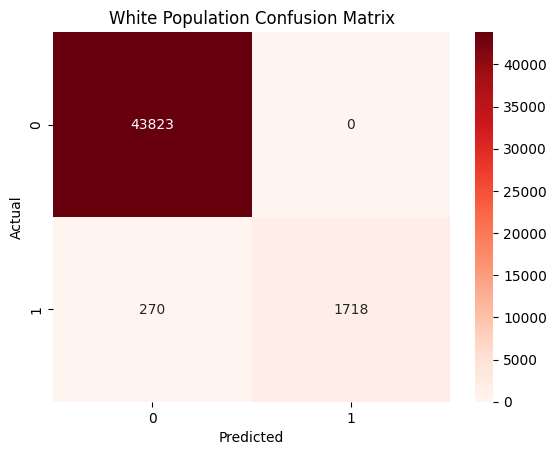

In [50]:
import seaborn as sns
plt.figure()
sns.heatmap(conf_matrix, annot=True, cmap="Reds", fmt="d", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title('White Population Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [51]:
feature_importances = model.feature_importances_

# Get the feature names
feature_names = X_train.columns

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
feature_importance_df = feature_importance_df.drop(1)
top_features = feature_importance_df.head(20)

In [52]:
del white_only, whites_encoded, X_train, X_test, y_train, y_test, cat_columns
gc.collect()

5365

In [53]:
top_white = white_no_ecz[top_features['Feature'].tolist()]
del white_no_ecz
gc.collect()

0

In [54]:
X_train_top, X_test_top, y_train_top, y_test_top = train_test_split(top_white, y, test_size=0.2, random_state=13)
model_top = RandomForestClassifier(random_state=95, class_weight = 'balanced')

model_top.fit(X_train_top, y_train_top)
y_pred_top = model_top.predict(X_test_top)
cm_top = confusion_matrix(y_test_top, y_pred_top)

accuracy_topw = accuracy_score(y_test_top, y_pred_top)
conf_matrix_topw = confusion_matrix(y_test_top, y_pred_top)

print(f'Accuracy: {accuracy_topw}')
print('Confusion Matrix:')
print(conf_matrix_topw)

Accuracy: 0.9928183187444064
Confusion Matrix:
[[43646   177]
 [  152  1836]]


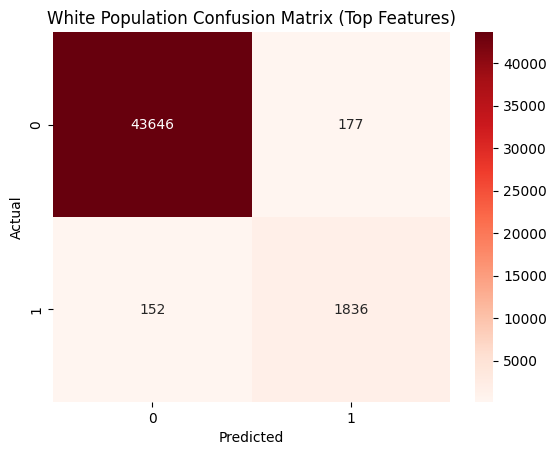

In [55]:
plt.figure()
sns.heatmap(conf_matrix_topw, annot=True, cmap="Reds", fmt="d", xticklabels=np.unique(y_test_top), yticklabels=np.unique(y_test_top))
plt.title('White Population Confusion Matrix (Top Features)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [56]:
del X_train_top, X_test_top, y_train_top, y_test_top

In [57]:
blacks_only = final_df[final_df['race'] == 'Black or African American']
blacks_only.loc[:, 'year_of_birth'] = blacks_only['date_of_birth'].dt.year
blacks_only = blacks_only.drop(['person_id', 'race', 'race_concept_id', 'gender_concept_id', 'ethnicity_concept_id','sex_at_birth_concept_id', 'observation_datetime', 'date_of_birth'], axis = 1)
cat_columns_blacks = blacks_only.select_dtypes(include=['object', 'category']).columns
blacks_encoded = pd.get_dummies(blacks_only, columns=cat_columns_blacks, drop_first=True)
X_blacks = blacks_encoded.drop(columns = ['Eczema'])
y_blacks = blacks_encoded['Eczema']

del blacks_only, blacks_encoded, cat_columns_blacks, final_df
gc.collect()

/tmp/ipykernel_719/3389684580.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  blacks_only.loc[:, 'year_of_birth'] = blacks_only['date_of_birth'].dt.year


0

In [58]:
column_diff = set(white_column_check) - set(X_blacks.columns)
column_diff = list(column_diff)
blacks_dict = {column_diff[i]: 'unknown' if white_dtype[i] == object else 0 for i in range(len(column_diff))}
add_df_blacks = pd.DataFrame(blacks_dict, index=X_blacks.index)

X_blacks_full = pd.concat([X_blacks, add_df_blacks], axis=1)
    
X_blacks_full = X_blacks_full[white_column_check]
X_blacks_full

,assisted_income,high_school_education,median_income,no_health_insurance,poverty,vacant_housing,deprivation_index,american_community_survey_year,mean_min_heart_rate,mean_max_heart_rate,...,Social Determinants of Health_Your age,Social Determinants of Health_Your ancestry or national origins,Social Determinants of Health_Your education or income level,Social Determinants of Health_Your gender,Social Determinants of Health_Your height,Social Determinants of Health_Your race,Social Determinants of Health_Your religion,Social Determinants of Health_Your sexual orientation,Social Determinants of Health_Your weight,Social Determinants of Health_unknown
2058,12.691355,90.872965,59190.503852,9.128200,16.356415,8.799737,0.313306,2017,-1.0,-1.0,...,False,False,False,False,False,False,False,False,True,False
2059,11.413995,89.254209,74163.235885,15.173288,12.792127,7.096994,0.309661,2017,-1.0,-1.0,...,False,False,False,False,False,False,False,False,False,True
2060,8.854928,90.369058,73169.472686,7.025661,12.719359,5.855450,0.272024,2017,-1.0,-1.0,...,False,False,False,False,False,True,False,False,False,False
2061,14.651095,89.479719,64686.534919,14.353899,18.930404,14.704588,0.347788,2017,-1.0,-1.0,...,False,False,False,False,False,False,False,False,False,True
2062,14.125852,88.840072,67853.608092,8.592618,11.947830,7.989274,0.300187,2017,-1.0,-1.0,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
313238,17.355981,85.665558,83951.707638,6.863952,17.753432,11.598508,0.314289,2017,-1.0,-1.0,...,False,False,False,False,False,False,False,False,False,True
313239,17.355981,85.665558,83951.707638,6.863952,17.753432,11.598508,0.314289,2017,-1.0,-1.0,...,False,False,False,False,False,False,False,False,False,True
313240,6.256623,90.124451,117154.740976,6.536388,6.784205,7.214019,0.208918,2017,-1.0,-1.0,...,False,False,False,False,False,False,False,False,False,True
313241,38.279736,70.896923,39407.415829,11.049983,29.653439,5.505385,0.485979,2017,-1.0,-1.0,...,False,False,False,False,False,False,False,False,False,True


In [59]:
y_pred_blacks = model.predict(X_blacks_full)
accuracy_blacks = accuracy_score(y_blacks, y_pred_blacks)
conf_matrix_blacks = confusion_matrix(y_blacks, y_pred_blacks)

print(f'Accuracy: {accuracy_blacks}')
print('Confusion Matrix:')
print(conf_matrix_blacks)

Accuracy: 0.9977307785469334
Confusion Matrix:
[[75561     0]
 [  178  2702]]


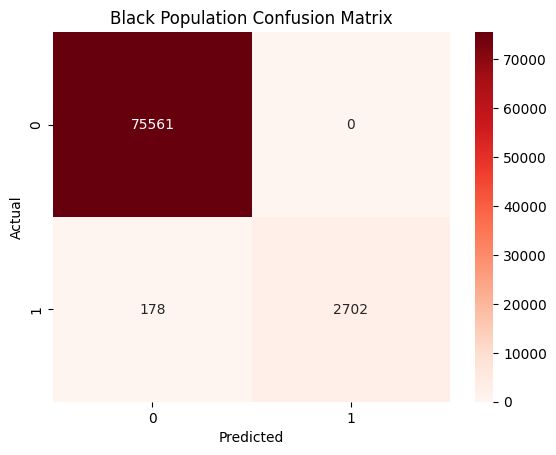

In [60]:
plt.figure()
sns.heatmap(conf_matrix_blacks, annot=True, cmap="Reds", fmt="d", xticklabels=np.unique(y_blacks), yticklabels=np.unique(y_blacks))
plt.title('Black Population Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [61]:
top_black = X_blacks[top_features['Feature'].tolist()]

In [62]:
y_pred_blacks_top = model_top.predict(top_black)
accuracy_topb = accuracy_score(y_blacks, y_pred_blacks_top)
conf_matrix_blacks_topb = confusion_matrix(y_blacks, y_pred_blacks_top)

print(f'Accuracy: {accuracy_topb}')
print('Confusion Matrix:')
print(conf_matrix_blacks_topb)

Accuracy: 0.9963921928583266
Confusion Matrix:
[[75420   141]
 [  142  2738]]


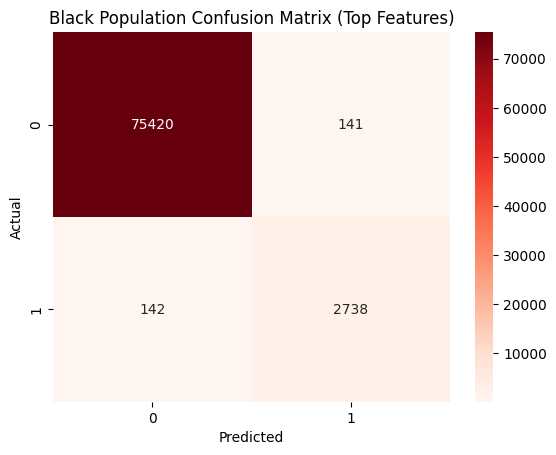

In [63]:
plt.figure()
sns.heatmap(conf_matrix_blacks_topb, annot=True, cmap="Reds", fmt="d", xticklabels=np.unique(y_blacks), yticklabels=np.unique(y_blacks))
plt.title('Black Population Confusion Matrix (Top Features)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [64]:
top_features.to_csv('top_features.csv', index=False)

In [65]:
from IPython.display import FileLink

# Create a download link
FileLink(r'top_features.csv')

/home/jupyter/workspaces/cbb740/top_features.csv